In [1]:
# подключим свой аккаунт ClearML
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=############################
%env CLEARML_API_SECRET_KEY=################################

# Импорт библиотек

In [14]:
import os  
import pandas as pd  
import spacy  # для токенизатора
import torch
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
from PIL import Image  
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from tqdm import tqdm
import torchvision.transforms as transforms
from clearml import Task
import matplotlib.pyplot as plt

In [5]:
# Подключимся к таске ClearML с нашим экспериментом
task = Task.get_task(task_id='3ef190eda11649e1b140054e10db0756')
task.started()

# Эмбэддинг слов

*Мы хотим преобразовать текст в числовые значения*
1. Нам нужен словарь, сопоставляющий каждое слово индексу
2. Нам нужно настроить набор данных Pytorch для загрузки данных
3. Настройка заполнения каждого батча (все предложения должны быть одной длины)

In [8]:
spacy_eng = spacy.load("en_core_web_sm")

***Токенезация предложений*** 

Токенезация = векторизация

Помимо эмбеддинга слов в вектора, используют специальные токены:

* `PAD` - используется для выравни вания предложений, если предложение больше установленной длины, слова обрезаются, если меньше - в предложение добавляется pad стольео раз, пока длина не достигнет необходимого значения

* `SOS` - "start of sentence" то же, что и <start> на картинке ниже - первый токен, который подается в декодер вместе с вектором, чтобы начать генерировать токены ответа
* `EOS` - "end of sentence" - то же, что и <end> на картинке ниже - как только декодер сгенерирует этот токен, мы считаем ответ полным (обычные знаки препинания для этой цели использовать нельзя, так как их значениея могут быть разные)

* `UNK` - "unknown token" - используется для замены редких слов, которые не вошли к ваш словарь. Например, предложение «Меня зовут guotong1999» будет переведено на «Меня зовут _unk_»

<img src='https://cloud.githubusercontent.com/assets/2272790/18410099/1d0a1c1a-7761-11e6-9fe1-bd2e5622b90a.png'>

In [9]:
# Создание словаря
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

#  Загрузка Flickr8k датасета

In [10]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Сохраняем картинку и описание
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Создаем словарь
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)



# Приводим описание картинок и их эмбеддинги к общему виду
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(root_folder, annotation_file, transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True,):

    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx))
    return loader, dataset



transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),])

loader, dataset = get_loader("./data/flickr8k/images/", "./data/flickr8k/captions.txt", transform=transform)

for idx, (imgs, captions) in enumerate(loader):
        print(imgs.shape)
        print(captions.shape)

torch.Size([32, 3, 224, 224])
torch.Size([20, 32])
torch.Size([32, 3, 224, 224])
torch.Size([19, 32])
torch.Size([32, 3, 224, 224])
torch.Size([23, 32])
torch.Size([32, 3, 224, 224])
torch.Size([23, 32])
torch.Size([32, 3, 224, 224])
torch.Size([25, 32])
torch.Size([32, 3, 224, 224])
torch.Size([24, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([22, 32])
torch.Size([32, 3, 224, 224])
torch.Size([25, 32])
torch.Size([32, 3, 224, 224])
torch.Size([19, 32])
torch.Size([32, 3, 224, 224])
torch.Size([27, 32])
torch.Size([32, 3, 224, 224])
torch.Size([20, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([19, 32])
torch.Size([32, 3, 224, 224])
torch.Size([22, 32])
torch.Size([32, 3, 224, 224])
torch.Size([24, 32])
torch.Size([32, 3, 224, 224])
torch.Size([23, 32])
torch.Size([32, 3, 224, 224])
t

# Модель

Модель подписей к изображениям состоит из кодировщика и декодера. В качестве кодировщика выступает линейный слой, который используется сразу после предобученной ***CNN***. Декодера - ***RNN***. 

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [11]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        # Загрузка предобученной CNN модели
        self.inception = models.inception_v3(
            weights=models.Inception_V3_Weights.DEFAULT, aux_logits=True)
        # Замена последнего слоя-классификатора на эмбеддер
        self.inception.fc = nn.Linear(
            self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        #features = self.inception(images)
        features = self.inception(images)[0]
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                #predicted = output.argmax(1)
                predicted = output.argmax()
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

# Обучение модели

In [16]:
# логгер для сохранения метрик в ClearML
log = task.logger

def train(hidden_size, num_epochs):
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder="./data/flickr8k/images",
        annotation_file="./data/flickr8k/captions.txt",
        transform=transform,
        num_workers=2,
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_CNN = False

    # Гиперпараметры
    embed_size = 128
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4


    # Инициализация
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Только тонкая настройка CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    model.train()

    for epoch in range(num_epochs):
        print('epoch: ', epoch)
        for idx, (imgs, captions) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )
            log.report_scalar(
                "Test",
                f'CE_loss_{hidden_size}', 
                iteration=len(train_loader)*epoch + idx, 
                value=loss)
            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

    return model

# Домашнее задание

Проанализируйте, как размер эмбеддинга влияет на качество модели.

Визуализируйте полученный результат подписи к нескольким изображениям, можно ли улучшить производительность сети?

In [1]:
# Обучим модель как в задании на 50 эпох
model = train(128, 50)
torch.save(model.state_dict(), 'model_emb_128.pt')

In [3]:
# обучим модель с большим эмбеддингом
model2 = train(256, 50)
torch.save(model2.state_dict(), 'model_emb_256.pt')

Посомтрим результаты обучения

![подпись](./2024-03-16_13-34-43.png)

Как видим, лосс у модели с большим эмбеддингом ниже в течение всего обучения(скачок в начале обусловлен тем, что я не правильно логировал и переписал значения CE_loss_128 значениями от 256, не стал переобучивать модель).

In [6]:
# посмотрим результаты
files = os.listdir("./data/flickr8k/images/")
files = ["./data/flickr8k/images/"+x for x in files]

In [12]:
# Загрузим модели
embed_size = 128
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
model =  CNNtoRNN(embed_size, 128, vocab_size, num_layers).to('cuda')
model.load_state_dict(torch.load('model_emb_128.pt'))

model2 =  CNNtoRNN(embed_size, 256, vocab_size, num_layers).to('cuda')
model2.load_state_dict(torch.load('model_emb_256.pt'))

<All keys matched successfully>

128 embed model - <SOS> a man in a black shirt and a black hat is standing in front of a crowd of people . <EOS> 
256 embed model - <SOS> a man and a woman are standing in front of a large building . <EOS> 


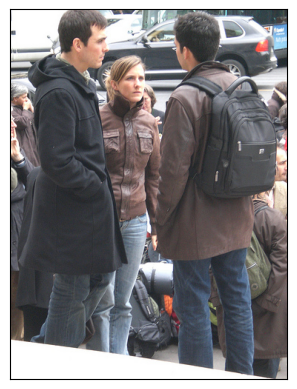

In [15]:
# Выбираем файл
file = files[0]
img = Image.open(file)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

# Инференс моделей (генерация подписи)
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
img_tensor = transform(img).cuda()

model.eval()
sentence = '128 embed model - '
for word in model.caption_image(img_tensor.unsqueeze(0), dataset.vocab):
    sentence += word + ' '
print(sentence)

model2.eval()
sentence = '256 embed model - '
for word in model2.caption_image(img_tensor.unsqueeze(0), dataset.vocab):
    sentence += word + ' '
print(sentence)

128 embed model - <SOS> a dog is running through a field of grass . <EOS> 
256 embed model - <SOS> a dog is jumping over a hurdle . <EOS> 


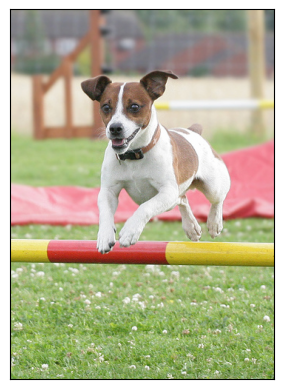

In [16]:
# Выбираем файл
file = files[100]
img = Image.open(file)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

# Инференс моделей (генерация подписи)
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
img_tensor = transform(img).cuda()

model.eval()
sentence = '128 embed model - '
for word in model.caption_image(img_tensor.unsqueeze(0), dataset.vocab):
    sentence += word + ' '
print(sentence)

model2.eval()
sentence = '256 embed model - '
for word in model2.caption_image(img_tensor.unsqueeze(0), dataset.vocab):
    sentence += word + ' '
print(sentence)

128 embed model - <SOS> a brown dog is running through the grass . <EOS> 
256 embed model - <SOS> a dog is running through the grass . <EOS> 


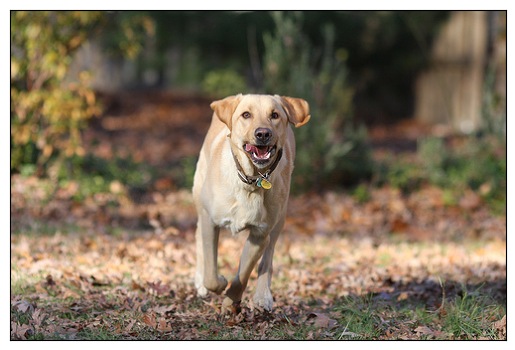

In [17]:
# Выбираем файл
file = files[1000]
img = Image.open(file)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

# Инференс моделей (генерация подписи)
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
img_tensor = transform(img).cuda()

model.eval()
sentence = '128 embed model - '
for word in model.caption_image(img_tensor.unsqueeze(0), dataset.vocab):
    sentence += word + ' '
print(sentence)

model2.eval()
sentence = '256 embed model - '
for word in model2.caption_image(img_tensor.unsqueeze(0), dataset.vocab):
    sentence += word + ' '
print(sentence)

128 embed model - <SOS> a group of people are standing in front of a <UNK> building . <EOS> 
256 embed model - <SOS> a group of people are standing in front of a large building . <EOS> 


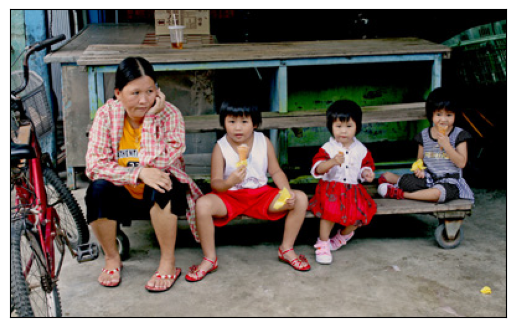

In [18]:
# Выбираем файл
file = files[2000]
img = Image.open(file)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

# Инференс моделей (генерация подписи)
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
img_tensor = transform(img).cuda()

model.eval()
sentence = '128 embed model - '
for word in model.caption_image(img_tensor.unsqueeze(0), dataset.vocab):
    sentence += word + ' '
print(sentence)

model2.eval()
sentence = '256 embed model - '
for word in model2.caption_image(img_tensor.unsqueeze(0), dataset.vocab):
    sentence += word + ' '
print(sentence)

128 embed model - <SOS> a brown dog is running through a field of grass . <EOS> 
256 embed model - <SOS> a dog is jumping over a hurdle . <EOS> 


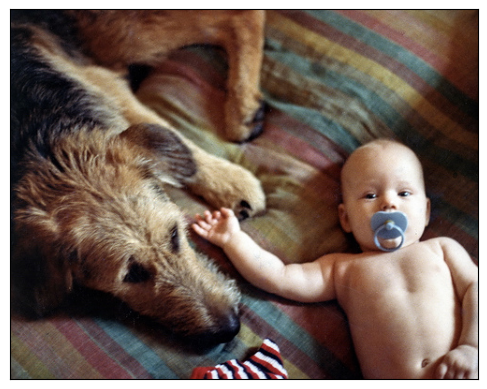

In [19]:
# Выбираем файл
file = files[3000]
img = Image.open(file)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

# Инференс моделей (генерация подписи)
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
img_tensor = transform(img).cuda()

model.eval()
sentence = '128 embed model - '
for word in model.caption_image(img_tensor.unsqueeze(0), dataset.vocab):
    sentence += word + ' '
print(sentence)

model2.eval()
sentence = '256 embed model - '
for word in model2.caption_image(img_tensor.unsqueeze(0), dataset.vocab):
    sentence += word + ' '
print(sentence)

Судя по первым двум фото, модель с большим эмбеддингом себя показывает лучше, однако далее результаты не однозначны. В целом можно сказать, обе модели не плохо обучились, но модель с большим крытыс эмбеддингом несколько лучше.